In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report,  precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  Input, Dropout, Conv2D, MaxPooling2D, Flatten

from pytorch_tabnet.tab_model import TabNetClassifier
import torch



In [2]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

In [61]:
df = pd.read_excel('df.xlsx')
print("Dimensions of the dataset:", df.shape)

nas_per_column = df.isna().sum()
columns_with_nas = nas_per_column[nas_per_column > 0]
print("\nColumns with missing values and their counts:")
print(columns_with_nas)

# to predict: without_formal_contract, envelope_wage, dep_self_empl, has_OR_would_have_undeclared_salary
#print("\nNames of columns:", df.columns.tolist())
columns_to_drop = ['without_formal_contract', 'envelope_wage', 'dep_self_empl', 'has_OR_would_have_undeclared_salary']

# Separate features and target
X = df.drop(columns=columns_to_drop, axis=1)
y = df['envelope_wage']

# Class imbalance
print('\nClass imbalance for envelope_wage :\n', df['envelope_wage'].value_counts())

Dimensions of the dataset: (27565, 130)

Columns with missing values and their counts:
Series([], dtype: int64)

Class imbalance for envelope_wage :
 0    26899
1      666
Name: envelope_wage, dtype: int64


# Class Balance: Undersample

In [62]:
# Define the undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# Resample the data
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of the resampled dataset:", X_resampled.shape)
print("Dimensions of train:", X_train.shape)
print("Dimensions of test:", X_test.shape)
print('\nClass balance for without_formal_contract :\n', y_resampled.value_counts())

Dimensions of the resampled dataset: (1332, 126)
Dimensions of train: (1065, 126)
Dimensions of test: (267, 126)

Class balance for without_formal_contract :
 0    666
1    666
Name: envelope_wage, dtype: int64


# 1. Random Forest

Training Set Accuracy: 0.9362
Test Set Accuracy: 0.8202
Confusion Matrix:
[[100  32]
 [ 16 119]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       132
           1       0.79      0.88      0.83       135

    accuracy                           0.82       267
   macro avg       0.83      0.82      0.82       267
weighted avg       0.82      0.82      0.82       267



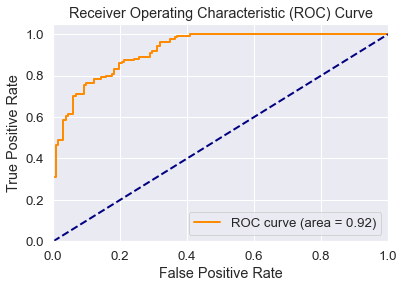

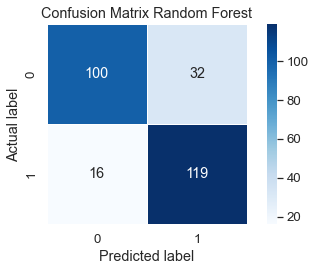

In [54]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Set the best parameters
best_params = {'max_depth':10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Train the model
best_rf.fit(X_train, y_train)

# Predict and evaluate on the training set
y_train_pred = best_rf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Set Accuracy: {training_accuracy:.4f}")

# Predict and evaluate on the test set
y_pred_RF = best_rf.predict(X_test) 
test_accuracy = accuracy_score(y_test, y_pred_RF)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_RF)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_RF))

# ROC Curve using predicted probabilities
y_pred_proba_RF = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_RF)
roc_auc_RF = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix Random Forest')

# Adjust layout
plt.tight_layout()
plt.show()

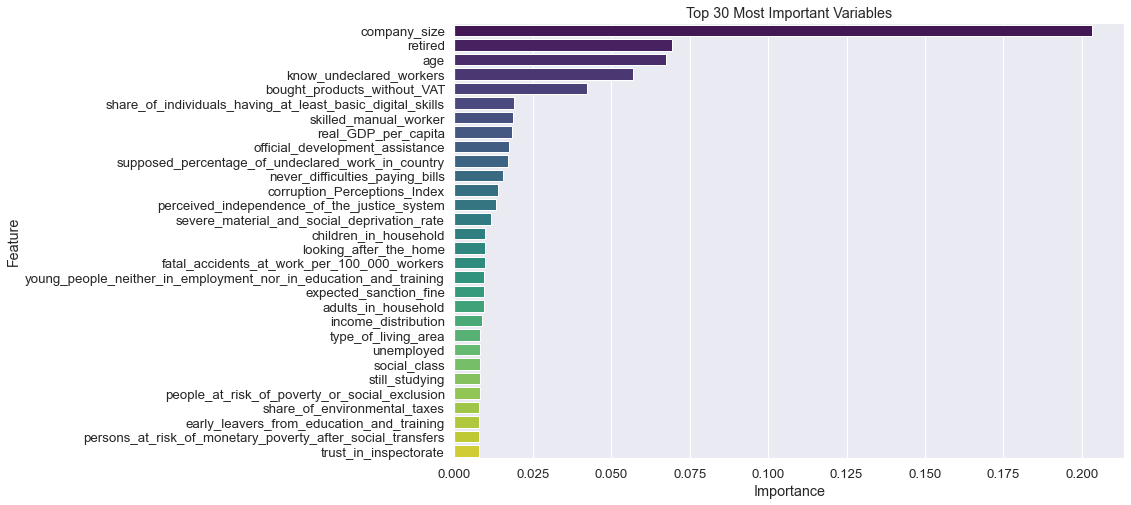

In [55]:

# Importance of variables
importances = best_rf.feature_importances_

# Get indices of top 30 features in descending order
top_indices = importances.argsort()[-30:][::-1]

# Get feature names
feature_names = X.columns

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': [feature_names[i] for i in top_indices], 'Importance': importances[top_indices]})

# Plot the importance of top 30 variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()

# SHAP 

In [56]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for class 1
shap_values = explainer.shap_values( X_test[:100])[:, :, 1] #impact on class 1

# Calculate mean SHAP values for each feature
mean_shap_values = shap_values.mean(axis=0)

# Get feature names
feature_names = X_test.columns

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values]

# Display the DataFrame
print(importance_df)


                             Feature  SHAP Value    Impact
0                                age    0.000015  Positive
1                            Belgium   -0.000238  Negative
2                            Denmark   -0.000023  Negative
3                            Germany   -0.000050  Negative
4                             Greece    0.000003  Positive
..                               ...         ...       ...
121     corruption_Perceptions_Index    0.000424  Positive
122    confidence_in_EU_institutions    0.000324  Positive
123  official_development_assistance    0.001424  Positive
124     share_of_environmental_taxes   -0.000441  Negative
125    general_government_gross_debt   -0.000210  Negative

[126 rows x 3 columns]


In [57]:
importance_df.to_csv('importance_shap_RF_100test_ew.csv', index=False)

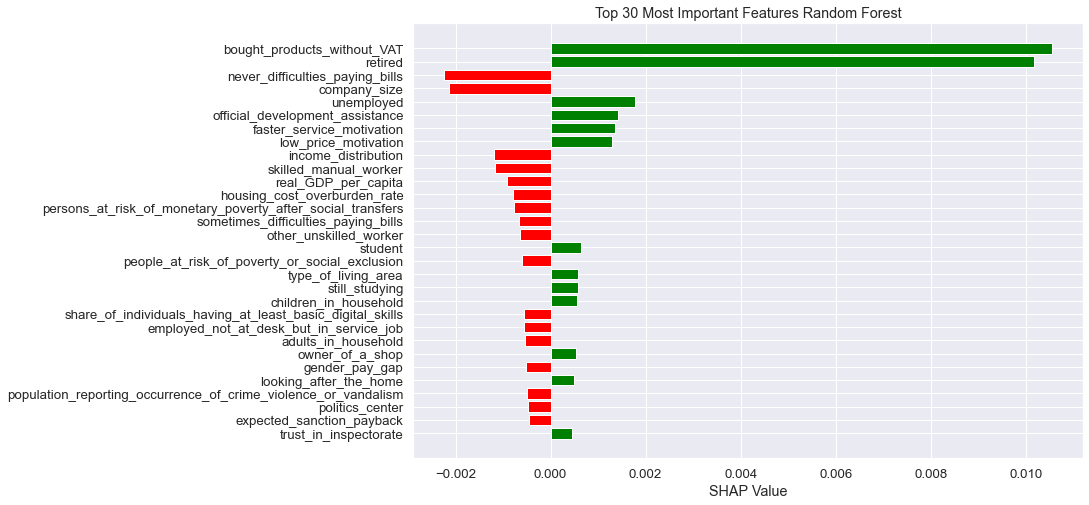

In [58]:
import matplotlib.pyplot as plt

# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()


# 2. MLP Neural Network

In [63]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model final MLP

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import shap
import pandas as pd

# Set seeds for reproducibility
np.random.seed(140)
tf.keras.utils.set_random_seed(44)
tf.random.set_seed(134)

# Initialize the model
model_MLP = Sequential(name='MLP')

# Add layers directly with numbers
model_MLP.add(Dense(126, activation='relu', input_shape=(126,)))
model_MLP.add(Dense(252, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(126, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(32, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(4, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(1, activation='sigmoid'))

# Compile the model
model_MLP.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy'])

# Assuming X_train and y_train are already defined
# Fit the model
model_MLP.fit(X_train, y_train, epochs=5, batch_size=1, verbose=0)



## SHAP

In [66]:
explainer_MLP = shap.KernelExplainer(model_MLP.predict,X_train)
shap_values_MLP = explainer_MLP.shap_values(X_test[:100],nsamples=100)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Using 1065 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 786us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 767us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 775us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 749us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 776us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 749us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 761us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 745us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 756us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 753us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 747us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 755us/step
1/1 

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.735e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 71 iterations, alpha=1.080e-02, previous alpha=1.080e-02, with an active set of 32 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 770us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 831us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 819us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 762us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 779us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 795us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 765us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 747us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 751us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 818us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 765us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 768us/step
1/1 

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.683e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=1.028e-02, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 2s 740us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 2s 741us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 756us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 789us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 792us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 2s 741us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 751us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 2s 745us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 2s 746us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 2s 746us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 761us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 768us/step
1/1 

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.093e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 90 iterations, alpha=9.587e-03, previous alpha=9.582e-03, with an active set of 39 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 746us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 784us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 2s 743us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 754us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 753us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 765us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 3s 751us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 2s 738us/step


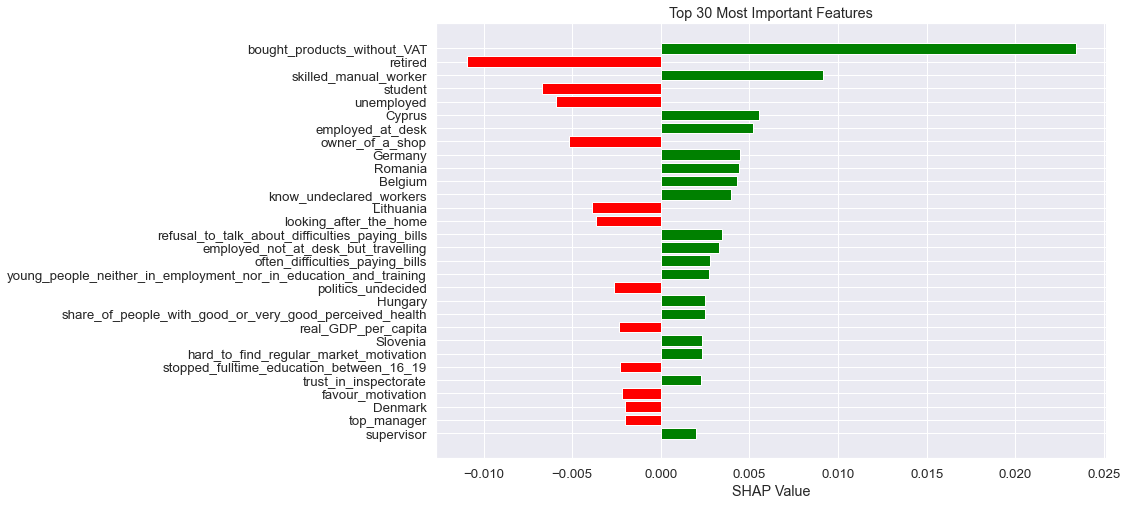

In [69]:
# Calculate mean SHAP values for each feature
mean_shap_values = shap_values_MLP.mean(axis=0).mean(axis=1)

# Get feature names
feature_names = X.columns.to_numpy()

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values]

import matplotlib.pyplot as plt

# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [70]:
importance_df.to_csv('importance_shap_MLP_100test_ew.csv', index=False)

## GRAFIC FARA TARI

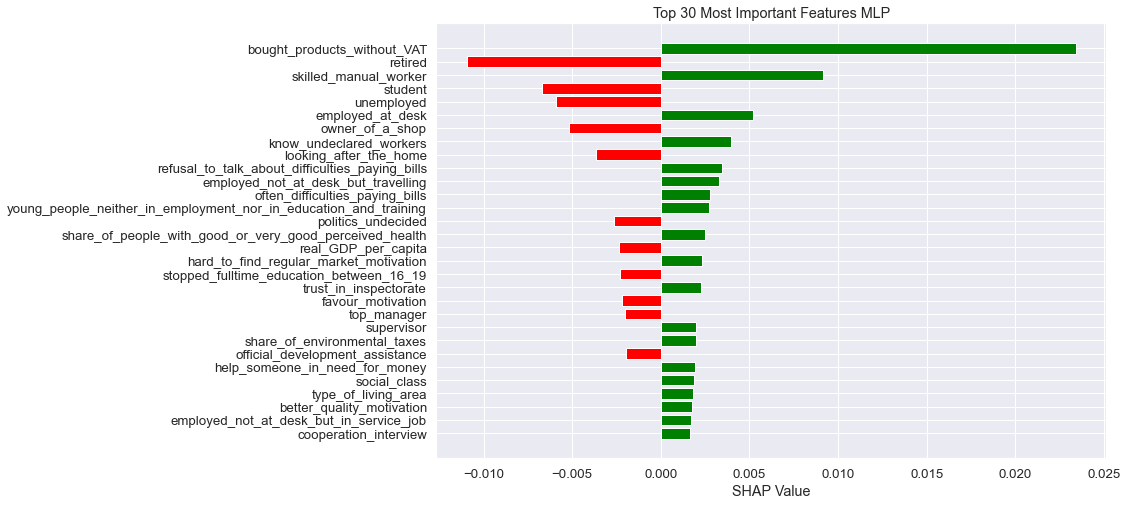

In [72]:
# FARA TARI
importance_df = pd.read_csv('importance_shap_MLP_100test_ew.csv')
importance_df= importance_df.drop(df.index[1:30])   #cut out countries


# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features MLP')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

# 3. Tab Net with CV

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Ensure reproducibility
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert pandas DataFrame to numpy array
X_train_array = X_train.values
X_test_array = X_test.values

# Initialize the TabNetClassifier with the best parameters
tabnet_model = TabNetClassifier(
    gamma=2.0,
    lambda_sparse=0.0,
    mask_type='sparsemax',
    n_a=64,
    n_d=8,
    n_independent=2,
    n_shared=1,
    n_steps=5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': 0.02}
)


# Define cross-validation strategy (Stratified K-Fold with 5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on training set
cv_scores = cross_val_score(tabnet_model, X_train_array, y_train, cv=skf, scoring='accuracy')
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: {:.2f}".format(cv_scores.mean()))

# Fit the model to the entire training data
tabnet_model.fit(X_train_array, y_train)


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.90355 |  0:00:00s
epoch 1  | loss: 0.82074 |  0:00:00s
epoch 2  | loss: 0.76748 |  0:00:00s
epoch 3  | loss: 0.72212 |  0:00:00s
epoch 4  | loss: 0.72236 |  0:00:00s
epoch 5  | loss: 0.71731 |  0:00:00s
epoch 6  | loss: 0.71067 |  0:00:01s
epoch 7  | loss: 0.70407 |  0:00:01s
epoch 8  | loss: 0.68523 |  0:00:01s
epoch 9  | loss: 0.68038 |  0:00:01s
epoch 10 | loss: 0.67089 |  0:00:01s
epoch 11 | loss: 0.67214 |  0:00:01s
epoch 12 | loss: 0.64536 |  0:00:01s
epoch 13 | loss: 0.63708 |  0:00:02s
epoch 14 | loss: 0.66223 |  0:00:02s
epoch 15 | loss: 0.64463 |  0:00:02s
epoch 16 | loss: 0.65266 |  0:00:02s
epoch 17 | loss: 0.62836 |  0:00:02s
epoch 18 | loss: 0.62819 |  0:00:02s
epoch 19 | loss: 0.62242 |  0:00:02s
epoch 20 | loss: 0.61396 |  0:00:03s
epoch 21 | loss: 0.61182 |  0:00:03s
epoch 22 | loss: 0.61335 |  0:00:03s
epoch 23 | loss: 0.61232 |  0:00:03s
epoch 24 | loss: 0.60128 |  0:00:03s
epoch 25 | loss: 0.59856 |  0:00:03s
epoch 26 | loss: 0.59995 |  0:00:03s
e

Training Accuracy: 0.6647887323943662
Testing Accuracy: 0.6479400749063671

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       132
           1       0.67      0.59      0.63       135

    accuracy                           0.65       267
   macro avg       0.65      0.65      0.65       267
weighted avg       0.65      0.65      0.65       267



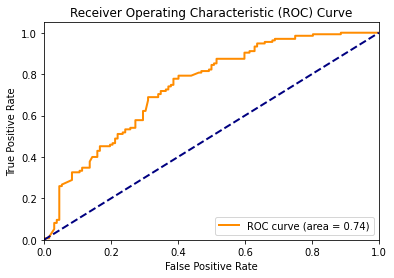

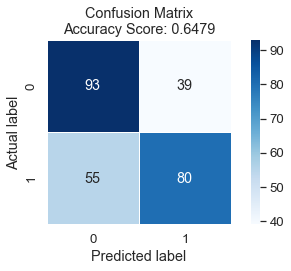

In [16]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Predict on training and testing data
y_train_pred = tabnet_model.predict(X_train_array)
y_test_pred_TABNET = tabnet_model.predict(X_test_array)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred_TABNET)

# Print train and test accuracy
print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)

# Generate classification report
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_test_pred_TABNET))

# Plot ROC curve
# Predict probabilities for the test set
y_prob_TABNET = tabnet_model.predict_proba(X_test_array)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_prob_TABNET)  
roc_auc_TABNET = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_TABNET)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot heatmap of the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_TABNET)
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix\nAccuracy Score: {test_acc:.4f}')

# Adjust layout
plt.tight_layout()
plt.show()

Top 30 Feature Importances:
                                               Feature  Importance
105          early_leavers_from_education_and_training    0.267529
37                                             retired    0.134655
108  share_of_individuals_having_at_least_basic_dig...    0.102285
12                                      United_Kingdom    0.082777
52                                 work_in_own_country    0.055115
59                                     risk_perception    0.052005
111  persons_outside_the_labour_force_due_to_caring...    0.049021
109                                     gender_pay_gap    0.040581
115        fatal_accidents_at_work_per_100_000_workers    0.024485
27                                             Romania    0.022517
118  population_reporting_occurrence_of_crime_viole...    0.017830
100                    in_work_at_risk_of_poverty_rate    0.015972
119  general_government_total_expenditure_on_law_co...    0.013797
31                     interested_

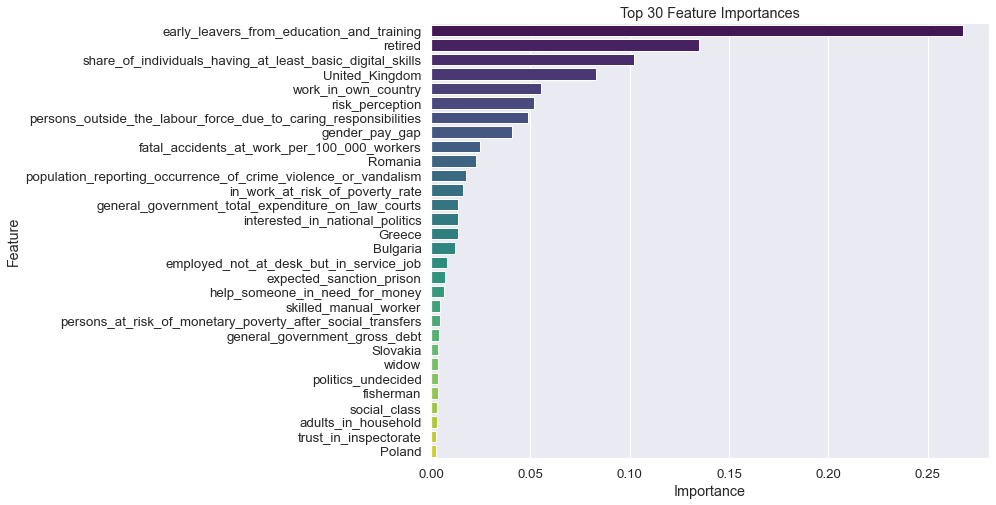

In [17]:
# Calculate feature importance
feature_importances = tabnet_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top 30 most important features
top_30_features = feature_importance_df.head(30)

# Print top 30 feature importance
print("Top 30 Feature Importances:")
print(top_30_features)

# Plot top 30 feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_features, palette='viridis')
plt.title('Top 30 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# SHAP

In [18]:
import shap

# Define the number of samples (K) for summarizing the background data
K = 100

# Use shap.kmeans() to summarize the background data
background_summary = shap.kmeans(X_train, K)

# Initialize the KernelExplainer with the summarized background data
explainer_TabNet= shap.KernelExplainer(tabnet_model.predict, background_summary)

# Calculate SHAP values using the KernelExplainer
shap_values_TabNet = explainer_TabNet.shap_values(X_test[:100], nsamples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.273e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 103 iterations, alpha=1.897e-03, previous alpha=1.897e-03, with an active set of 34 regressors.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well contro

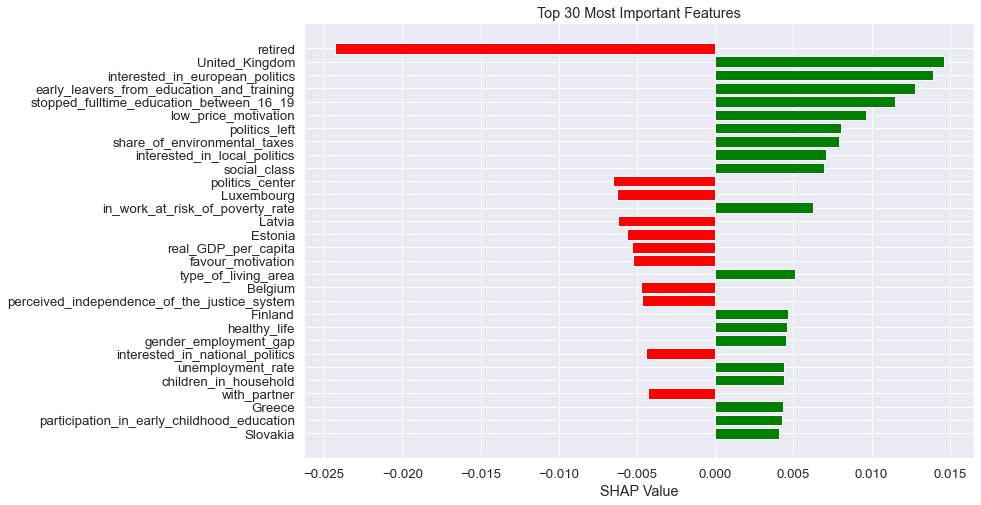

In [19]:

# Calculate mean SHAP values across the samples
mean_shap_values = shap_values_TabNet.mean(axis=0)

# Get feature names
feature_names = X.columns.to_numpy()

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values]

import matplotlib.pyplot as plt

# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [20]:
importance_df.to_csv('importance_shap_TabNet_100test_ew.csv', index=False)

# Fara tari

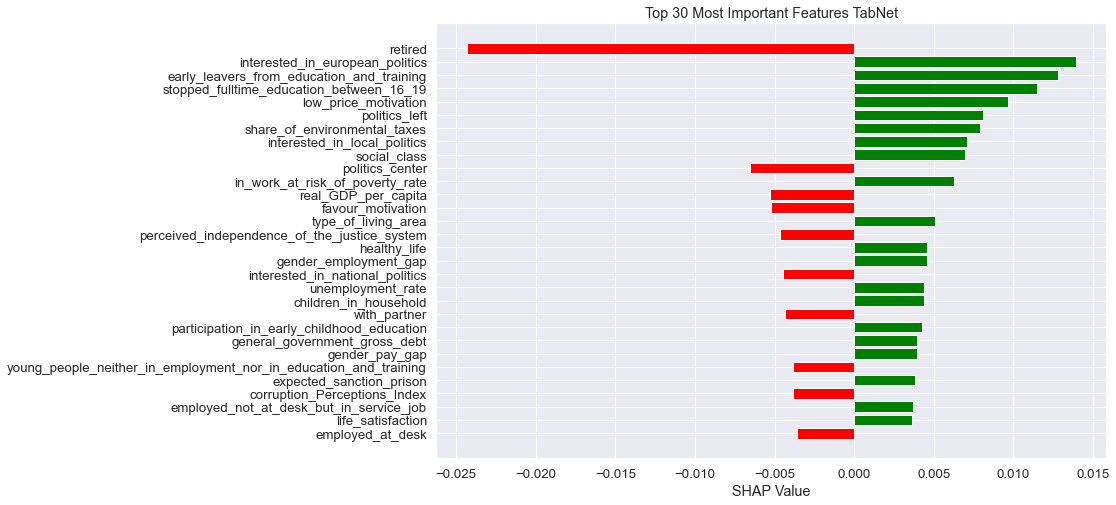

In [32]:
# FARA TARI
importance_df = pd.read_csv('importance_shap_TabNet_100test_ew.csv')
importance_df= importance_df.drop(df.index[1:30])   #cut out countries


# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features TabNet')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

# 4. Convolutional Neural Networks

In [22]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#SET SEED
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of X_train:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dimensions of X_train: (1065, 126)
Dimensions of X_test: (267, 126)
Dimensions of y_train: (1065,)
Dimensions of y_test: (267,)


In [23]:

#Reshape the data into 2D grid-like structure based on the data's dimensions
# Here, we reshape it into a 14x9 grid
X_train_reshaped = X_train_scaled.reshape(-1, 14, 9, 1)
X_test_reshaped = X_test_scaled.reshape(-1, 14, 9, 1)
print("Dimensions of X_train_reshaped:", X_train_reshaped.shape)
print("Dimensions of X_test_reshaped:", X_test_reshaped.shape)


Dimensions of X_train_reshaped: (1065, 14, 9, 1)
Dimensions of X_test_reshaped: (267, 14, 9, 1)


## MODEL CNN FINAL 

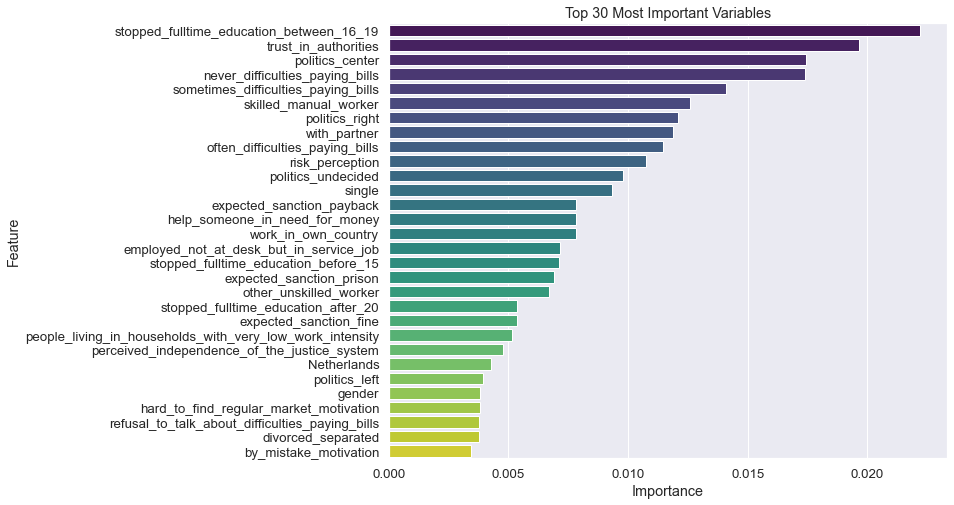

In [24]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Define and compile the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14, 9, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=5, batch_size=1, shuffle=False, verbose=0)

# Function to compute integrated gradients
@tf.function
def integrated_gradients(input_data):
    baseline = tf.zeros_like(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        predictions = model(input_data)
    grads = tape.gradient(predictions, input_data)
    integrated_grads = (input_data - baseline) * grads
    return tf.reduce_mean(integrated_grads, axis=0)

# Compute integrated gradients for each sample in the test set
ig_list = []
for sample in X_test_reshaped:
    ig = integrated_gradients(tf.convert_to_tensor([sample]))
    ig_list.append(ig.numpy())

# Calculate the mean importance across the test set
feature_importance = np.mean(ig_list, axis=0)

# Flatten feature_importance if it's not already 1D
feature_importance = feature_importance.flatten()

# Assuming X_train_reshaped was reshaped from a DataFrame X, with columns corresponding to the original feature names
input_feature_names = [f"Feature_{i}" for i in range(X_train_reshaped.shape[1] * X_train_reshaped.shape[2])]
input_feature_names = list(X.columns)

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': input_feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select only the top 30 most important variables
top_30_importance_df = importance_df.head(30)

# Plot the importance of top 30 variables
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()


# SHAP

In [25]:

#1.0	1.0 	1.0 	 2.0	[32, 32, 32]	['tanh', 'tanh', 'tanh']	binary_crossentropy 	Adamax

import numpy as np
import tensorflow as tf
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch

# Set seeds
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for CNN input
X_train_reshaped = X_train_scaled.reshape(-1, 14, 9, 1)
X_test_reshaped = X_test_scaled.reshape(-1, 14, 9, 1)

# Initialize the CNN model
model_CNN = Sequential()
model_CNN.add(Input(shape=(14, 9, 1)))  # Input layer
model_CNN.add(Conv2D(filters=32, kernel_size=(3, 3), activation='tanh'))  # Convolutional layer 1
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling layer 1
model_CNN.add(Flatten())  # Flatten layer
model_CNN.add(Dense(units=32, activation='tanh'))  # Dense layer 1
model_CNN.add(Dense(units=32, activation='tanh'))  # Dense layer 2
model_CNN.add(Dense(units=1, activation='sigmoid'))  # Output layer

# Compile the model
model_CNN.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy'])



In [26]:

# Train the model
model_CNN.fit(X_train_reshaped, y_train, epochs=5, batch_size=1, shuffle=False, verbose=0)

# Define a function to predict with the model and reshape the input
def predict_with_reshape(data):
    reshaped_data = data.reshape(-1, 14, 9, 1)
    return model_CNN.predict(reshaped_data)

# Define the number of samples (K) for summarizing the background data
K = 100

# Use shap.kmeans() to summarize the background data
background_summary = shap.kmeans(X_train_reshaped.reshape(X_train_reshaped.shape[0], -1), K)

# Initialize the KernelExplainer with the summarized background data
explainer_CNN = shap.KernelExplainer(predict_with_reshape, background_summary)


# Select the first 100 samples from the test set
X_test_reshaped_first_100 = X_test_reshaped[:100]
X_test_reshaped_first_100_flat = X_test_reshaped_first_100.reshape(X_test_reshaped_first_100.shape[0], -1)

# Calculate SHAP values using the KernelExplainer
shap_values_CNN = explainer_CNN.shap_values(X_test_reshaped_first_100_flat, nsamples=100)

# Reshape SHAP values to original 14x9 features
shap_values_original = np.array(shap_values_CNN).reshape(-1, 14, 9)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.832e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.961e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. a

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=6.733e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 137 iterations, alpha=1.203e-03, previous alpha=1.203e-03, with an active set of 40 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 51 iterations, alpha=4.032e-04, previous alpha=4.031e-04, with an active set of 34 regressors.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=8.405e-04, with an active set of 30 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 37 iterations, i.e. alpha=8.377e-04, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.376e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 81 iterations, alpha=2.032e-02, previous alpha=2.032e-02, with an active set of 28 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.613e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=4.224e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. a

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.898e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 131 iterations, alpha=9.983e-03, previous alpha=9.983e-03, with an active set of 34 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.228e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 107 iterations, alpha=8.039e-03, previous alpha=8.031e-03, with an active set of 40 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


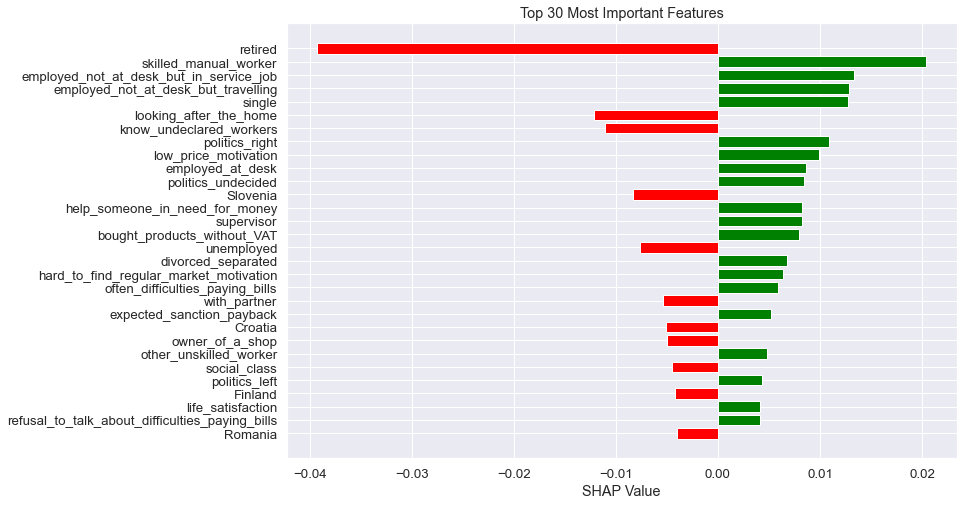

In [28]:
# Calculate mean SHAP values for each feature
mean_shap_values = shap_values_original.mean(axis=0)

# Get feature names (assuming you have feature names in X.columns)
feature_names = X.columns.to_numpy()

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values.flatten()})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values.flatten()]


# Get the top 30 most important features
import matplotlib.pyplot as plt
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [29]:
importance_df.to_csv('importance_shap_CNN_100test_ew.csv', index=False)

# Fara tari

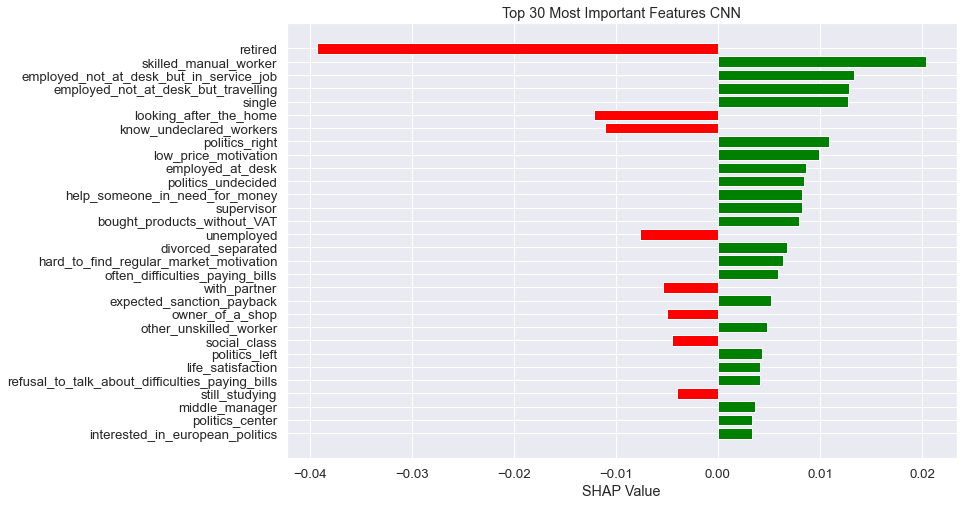

In [31]:
# FARA TARI
importance_df = pd.read_csv('importance_shap_CNN_100test_ew.csv')
importance_df= importance_df.drop(df.index[1:30])   #cut out countries


# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features CNN')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()